In [73]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc
from tqdm.notebook import tqdm
from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
from jobs.theory_lapse.isca.load_ds_quant import ds_quant

### Fraction of days used
In the scaling factor computation, we only include days for which the vertical `mod_parcel1` profile is good. We define *good* as having the error less than 25% and having a smaller error than the `const1` method.

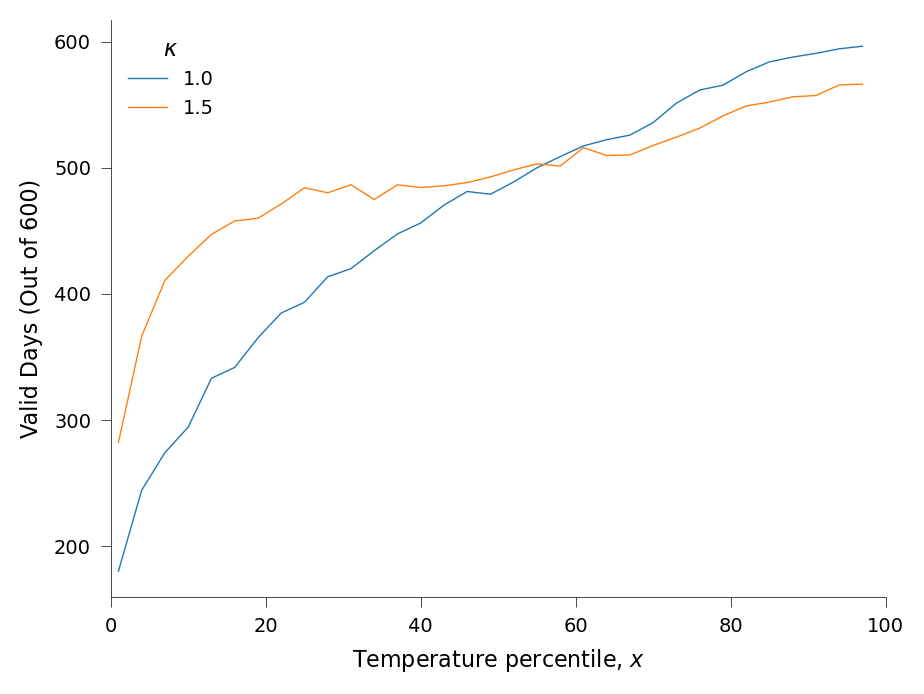

In [4]:
error = {
    key: np.abs(ds_quant[f'{key}1_error'].sum(dim='layer') / ds_quant[f'{key}1_integral'].sum(dim='layer') * 100).isel(
        surf=0)
    for key in ['mod_parcel', 'const']}
mask_use = (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])

lat_weights = np.cos(np.deg2rad(ds_quant.lat))
percentile_label = 'Temperature percentile, $x$'

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average(mask_use.sum(dim='sample').isel(tau_lw=i), axis=1, weights=lat_weights),
            label=f"{mask_use.tau_lw.values[i]:.1f}")
ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
ax.legend(title='$\kappa$')
plt.show()

## Principal Component Analysis
### Initialize data
We initialize data by subtracting the reference values. We obtain reference value for each latitude, and `tau_lw` value. We only use the masked points which have low error for the `mod_parcel1` method to compute the reference values.

In [7]:
ds_pca = ds_quant[['PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']].isel(surf=0)
ds_pca['lapse_mod_D'] = ds_pca.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_pca['lapse_mod_M'] = ds_pca.mod_parcel1_lapse.isel(layer=1) / 1000
ds_pca = ds_pca.drop_vars(['mod_parcel1_lapse'])
ref_method = 'actual'  # Take actual mean values
# ref_method = 'custom'       # Assume follows SQE, and no RH change with warming
if ref_method == 'actual':
    ref_vals = {key: ds_pca[key].where(mask_use).mean(dim=['quant', 'sample']) for key in ds_pca}
else:
    ref_vals = {key: ds_pca[key].where(mask_use).isel(tau_lw=0).mean(dim=['quant', 'sample']) for key in
                ['PREFHT', 'rh_REFHT']}
    ref_vals['lapse_mod_D'] = ref_vals['PREFHT'] * 0
    ref_vals['lapse_mod_M'] = ref_vals['PREFHT'] * 0
ref_vals['TREFHT'] = ds_quant.TREFHT.isel(surf=0).where(mask_use).mean(dim=['quant', 'sample'])
ds_ref = xr.Dataset(ref_vals)

# Compute ref
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)  # make function work with xarray
ds_ref['T_ft_env'] = get_temp_mod_parcel_xr(ref_vals['rh_REFHT'], ref_vals['PREFHT'], ds_quant.p_ft,
                                            ref_vals['lapse_mod_D'],
                                            ref_vals['lapse_mod_M'], ref_vals['TREFHT'],
                                            temp_surf_lcl_calc=ds_quant.temp_surf_lcl_calc)
for key in ds_pca:
    ds_pca[key] = ds_pca[key] - ds_ref[key]

### Correlation between variables
Some variables are correlated as shown below e.g. $T_{FT}$ is larger for smaller $p_s$ and $\eta_D$ is larger for smaller $r_s$.

These correlations indicate the need to do PCA on the raw variables before clustering. The motivation to do clustering can also be seen here, with distinct clusters apparent e.g. there appears to be a dry and moist regime for the highest latitude (yellow), but few points with $r_s\approx 0$.

In the plot below, a separate reference value is removed for each latitude and $\kappa$. Hence a different set of markers for each of these, all centered around zero for each variable. Only masked points are shown, for which the `mod_parcel` fitting is appropriate.

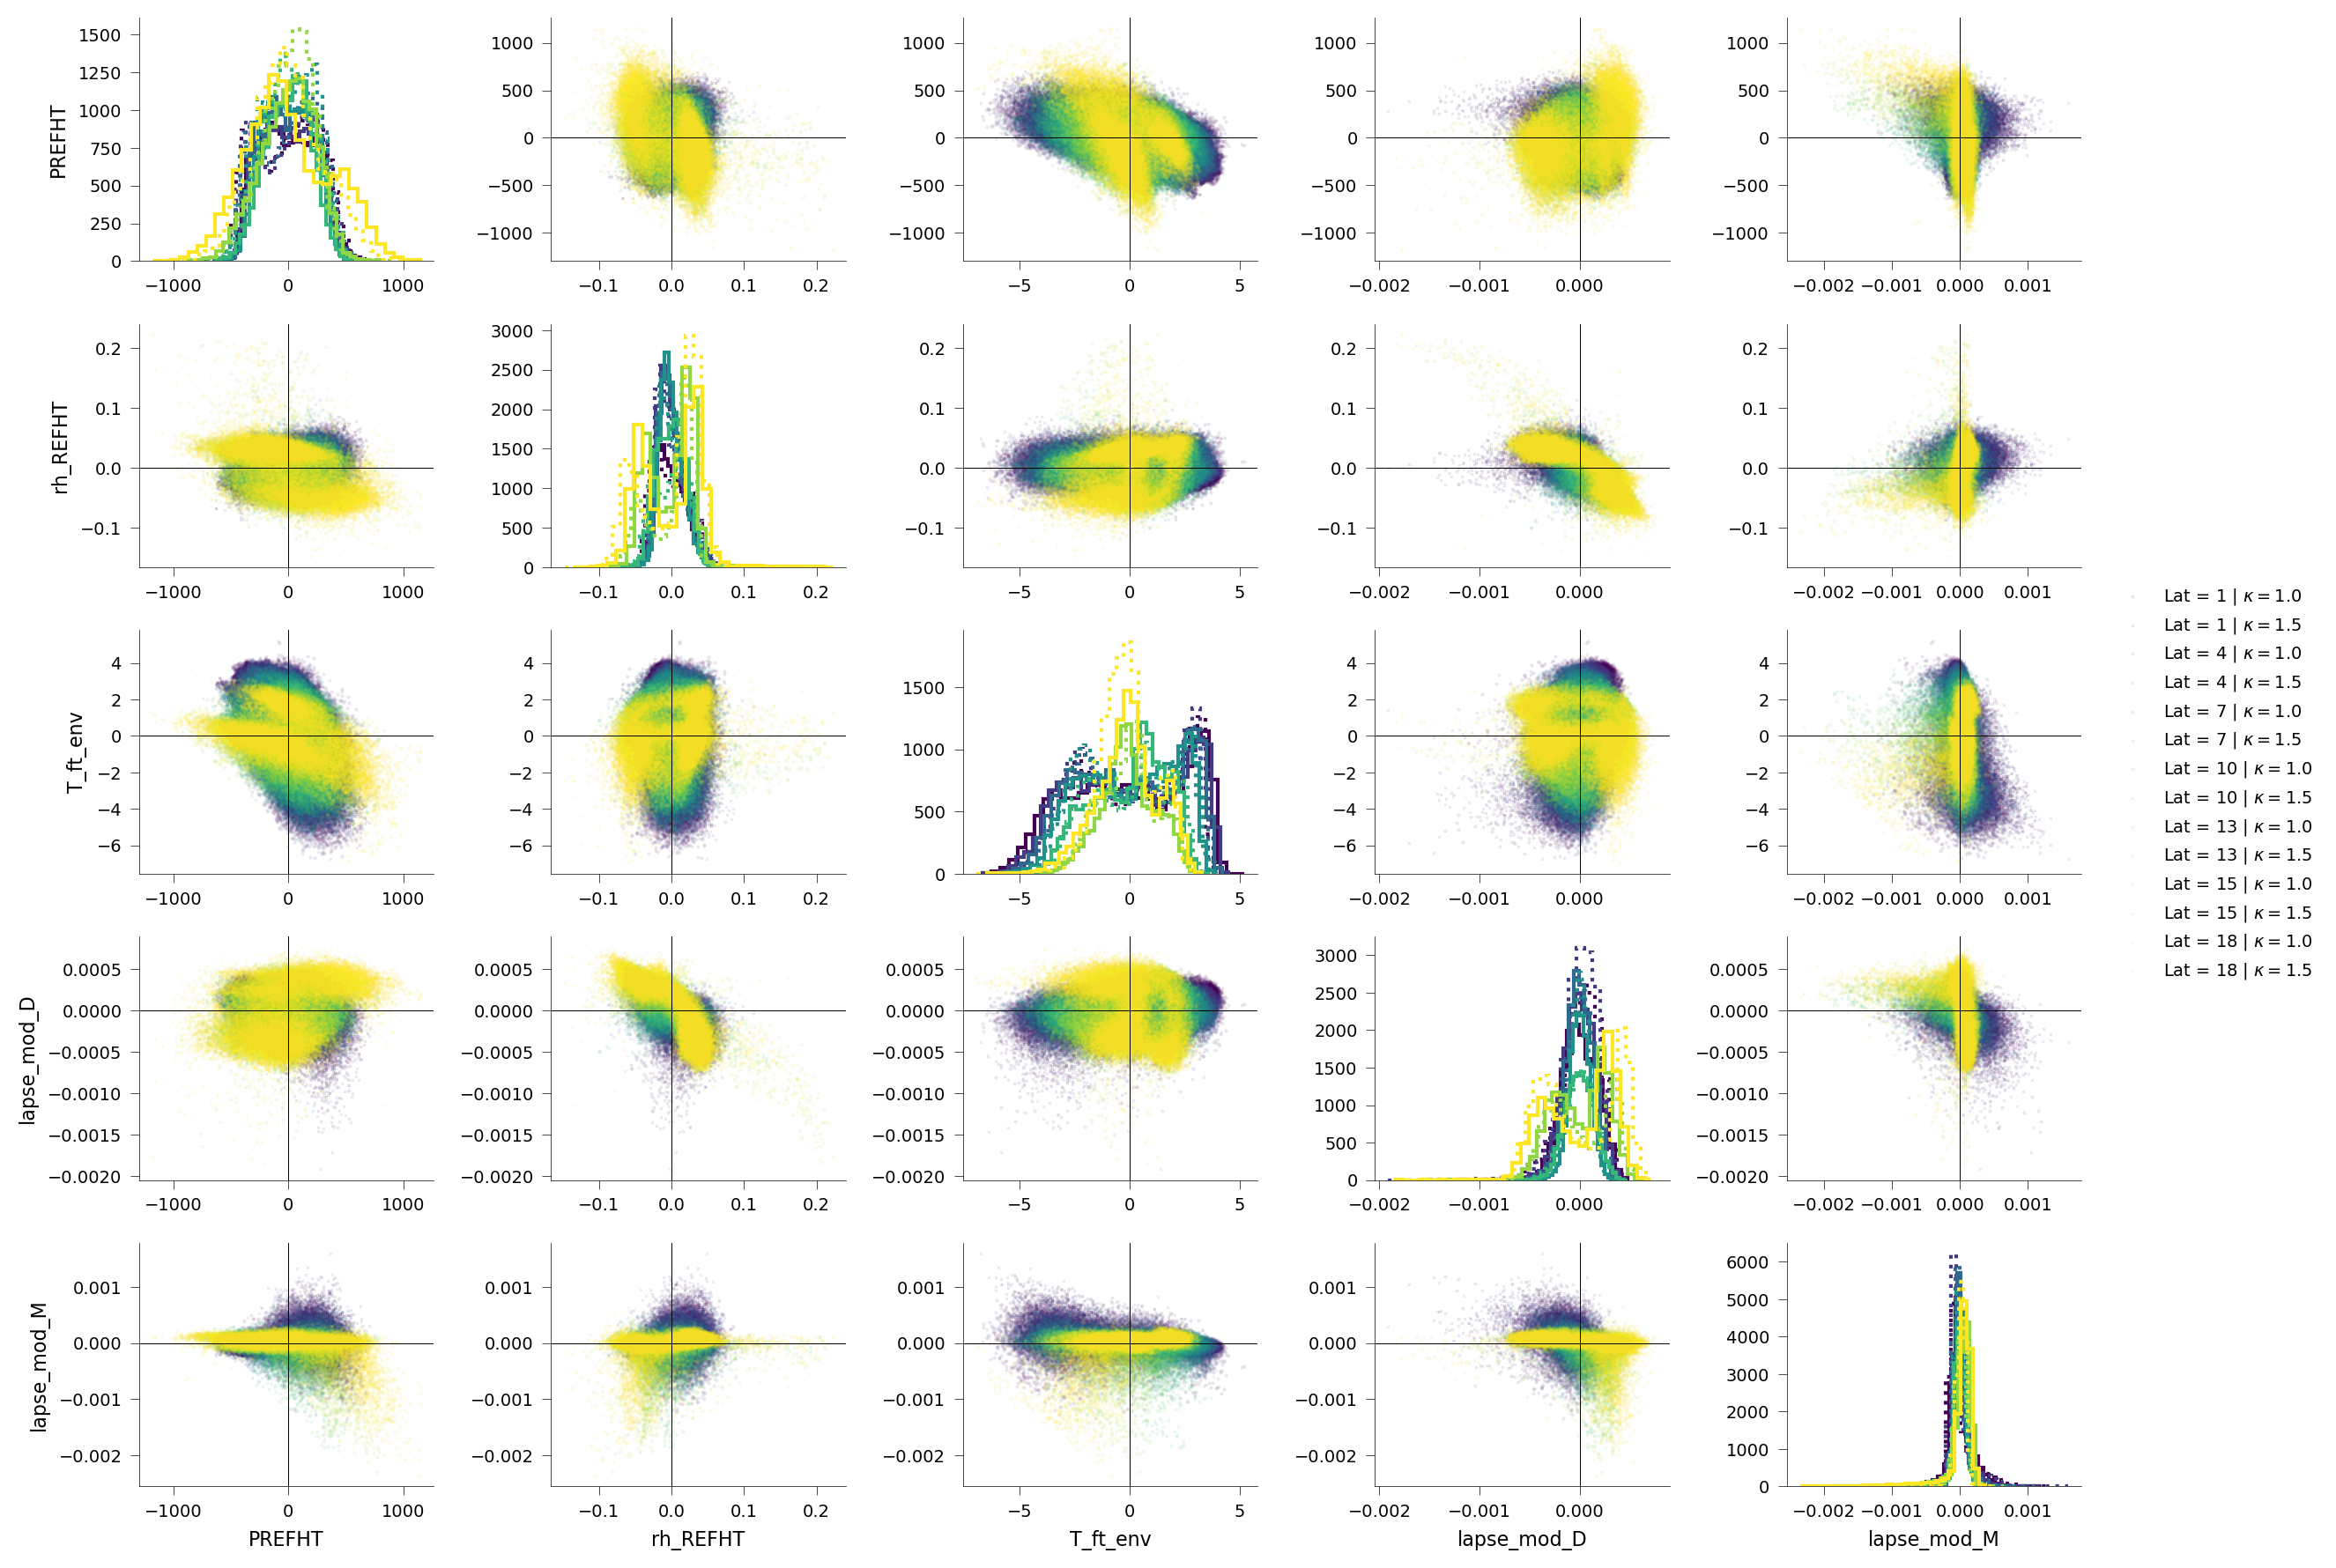

In [29]:
n_var = len(ds_pca.data_vars)
# Unique values for coloring/markers

# Assign colors and markers
colors = plt.cm.viridis(np.linspace(0, 1, len(ds_pca.lat)))
markers = ['.', 'x']  # extend if needed

fig, axes = plt.subplots(n_var, n_var, squeeze=False)
fig_resize(fig, 12)

for i, var_y in enumerate(list(ds_pca.data_vars)):
    for j, var_x in enumerate(list(ds_pca.data_vars)):
        ax = axes[i, j]
        for lat_idx, lat in enumerate(ds_pca.lat):
            for tau_idx, tau in enumerate(ds_pca.tau_lw):
                # Filter data for specific latitude and tau_lw
                x = ds_pca[var_x].where(mask_use).sel(lat=lat, tau_lw=tau)
                y = ds_pca[var_y].where(mask_use).sel(lat=lat, tau_lw=tau)
                if i == j:
                    # Diagonal: histogram line
                    ax.hist(x.values.flatten(), bins=30, color=colors[lat_idx], linestyle=':' if tau_idx == 1 else '-',
                            histtype='step', linewidth=1.5)
                else:
                    ax.scatter(x, y, color=colors[lat_idx], marker=markers[tau_idx],
                               label=f'Lat = {lat:.0f} | $\kappa = {tau:.1f}$', s=1, alpha=0.1)
                    ax.axhline(0, color='k', lw=ax_linewidth)
                    ax.axvline(0, color='k', lw=ax_linewidth)

        if i == n_var - 1:
            ax.set_xlabel(var_x)
        if j == 0:
            ax.set_ylabel(var_y)
        # ax.grid(True)

# Optional: create a single legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center')
plt.tight_layout()
plt.show()

### PC Results
Below I keep the first 3 PCs and plot how surface temperature varies with the PCs, along with the loadings which can be used to understand the surface temperature dependence.

In [31]:
pc_output = pca_on_xarray(xr.concat(list(ds_pca.values()), dim="feature"), n_modes=3, feature_dim_name="feature",
                          valid=mask_use)

In [62]:
def get_temp_surf_from_pc(pc_x_coef, pc_y_coef, pc_eof=pc_output[0], pc_mean=pc_output[2], pc_std=pc_output[3],
                          ds_ref=ds_ref.isel(lat=0, tau_lw=0), pc_x_mode_ind=0, pc_y_mode_ind=2):
    # pc_coef should be n_mode x n_vals
    # pc_eof should be n_mode x n_feature
    # Returns n_pc1_coef x n_pc2_coef
    var = pc_x_coef[:, np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_x_mode_ind).values[np.newaxis, np.newaxis]
    var = var + pc_y_coef[np.newaxis, : np.newaxis, np.newaxis] * pc_eof.isel(mode=pc_y_mode_ind).values[
        np.newaxis, np.newaxis]
    var = var * pc_std.values[np.newaxis, np.newaxis] + pc_mean.values[np.newaxis, np.newaxis]
    # var1 = pc1_coef[:, np.newaxis] * (pc_eof.isel(mode=0) * pc_std).values[np.newaxis]
    # var2 = pc2_coef[:, np.newaxis] * (pc_eof.isel(mode=1) * pc_std).values[np.newaxis]
    # var = var1[:, np.newaxis] + var2[np.newaxis]
    # var = var + pc_mean.values[np.newaxis, np.newaxis]
    p_surf = var[:, :, 0] + float(ds_ref['PREFHT'])
    rh_surf = var[:, :, 1] + float(ds_ref['rh_REFHT'])
    temp_ft_env = var[:, :, 2] + float(ds_ref['T_ft_env'])
    lapse_mod_D = var[:, :, 3] + float(ds_ref['lapse_mod_D'])
    lapse_mod_M = var[:, :, 4] + float(ds_ref['lapse_mod_M'])
    get_temp = np.vectorize(get_temp_mod_parcel)
    return get_temp(rh_surf, p_surf, ds_quant.p_ft, lapse_mod_D, lapse_mod_M, None, temp_ft_env,
                    ds_quant.temp_surf_lcl_calc)

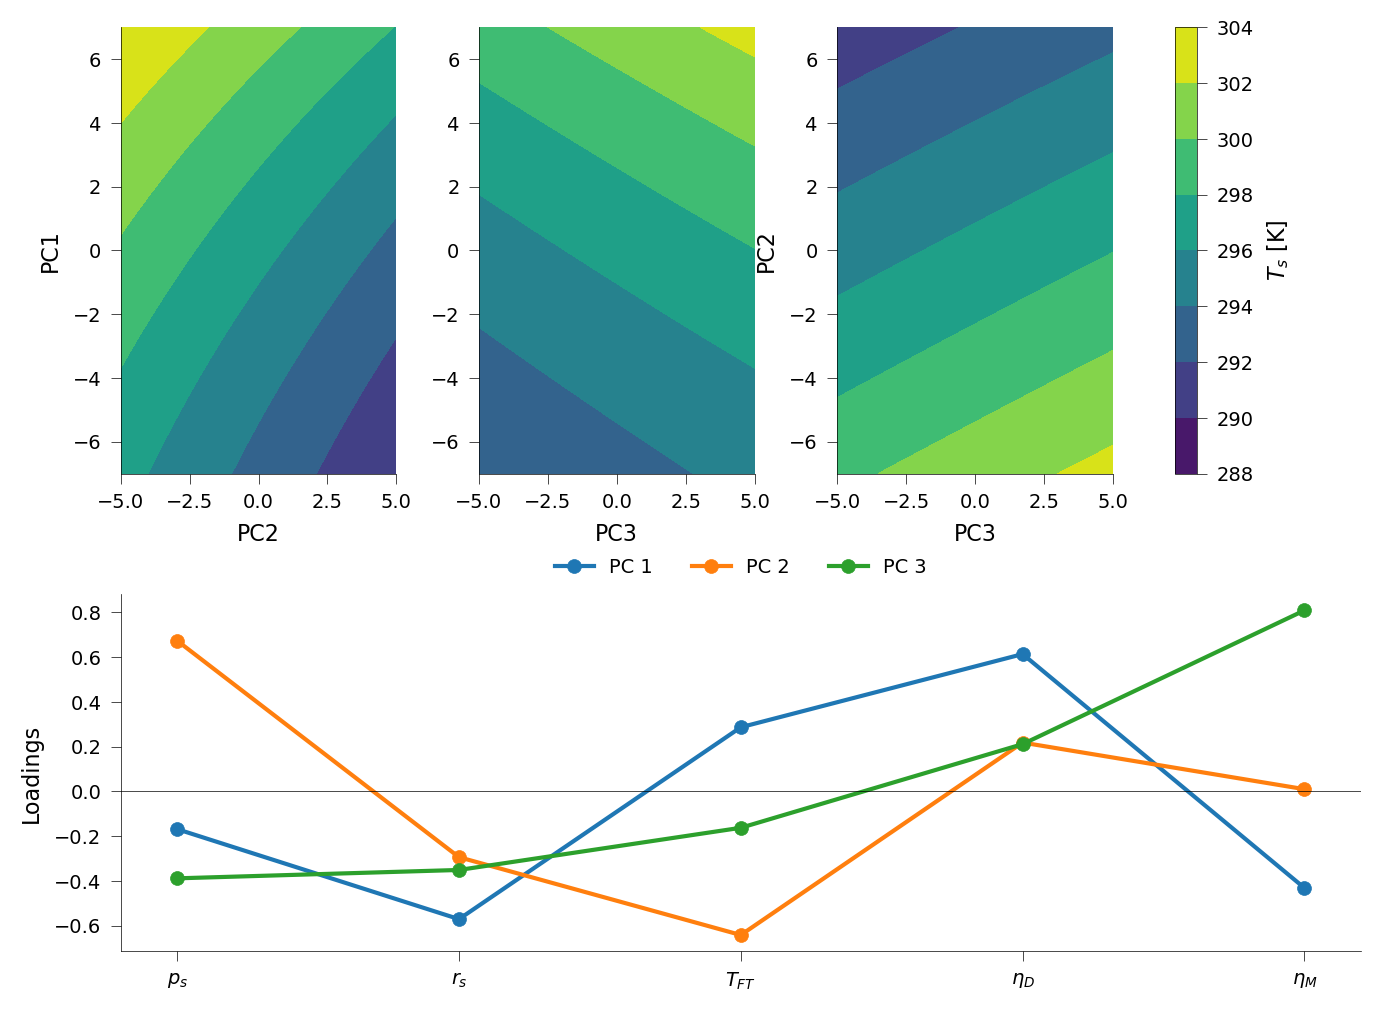

In [70]:
pc_x_coef_plot = np.arange(-5, 5.5, 0.5)
pc_y_coef_plot = np.arange(-7, 7.5, 0.5)

# Generate temperature surfaces
temp_surf_0_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=1, pc_y_mode_ind=0)
temp_surf_2_0 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=0)
temp_surf_2_1 = get_temp_surf_from_pc(pc_x_coef_plot, pc_y_coef_plot, pc_x_mode_ind=2, pc_y_mode_ind=1)

# Use gridspec to span bottom row
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.8], hspace=0.3, wspace=0.3)

# Top row: contour plots
ax0 = fig.add_subplot(gs[0, 0])
fig_resize(fig, 8)
im0 = ax0.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_0_1.T, levels=np.arange(288, 306, 2))
ax0.set_xlabel('PC2')
ax0.set_ylabel('PC1')

ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_0.T, levels=np.arange(288, 306, 2))
ax1.set_xlabel('PC3')

ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.contourf(pc_x_coef_plot, pc_y_coef_plot, temp_surf_2_1.T, levels=np.arange(288, 306, 2))
ax2.set_xlabel('PC3')
ax2.set_ylabel('PC2')

# Colorbar for top row
plt.colorbar(im2, ax=[ax0, ax1, ax2], label='$T_s$ [K]')

# Bottom row: single axis spanning all columns
ax_line = fig.add_subplot(gs[1, :])
for mode in range(pc_output[0].mode.size):
    ax_line.plot(np.arange(5), pc_output[0].isel(mode=mode), label=f'PC {mode + 1}', color=f"C{mode}", marker='o',
                 lw=1.5, markersize=5)
ax_line.set_xticks(np.arange(pc_output[0].feature.size))
ax_line.set_xticklabels(['$p_s$', '$r_s$', '$T_{FT}$', '$\eta_D$', '$\eta_M$'])
ax_line.set_ylabel('Loadings')
ax_line.legend(ncol=3, bbox_to_anchor=(0.5, 1.00), loc='lower center')
ax_line.axhline(0, color='k', lw=ax_linewidth)
plt.show()


In [93]:
def cluster_pcs(pcs: xr.DataArray, n_clusters: int, mask: xr.DataArray) -> xr.DataArray:
    """Cluster PCA coefficients and return cluster labels for each sample.

    Args:
        pcs: PCA coefficients with dims (quant, tau_lw, lat, sample, mode).
        n_clusters: Number of clusters.

    Returns:
        DataArray of cluster labels with dimension 'sample'.
    """
    pcs_stacked = pcs.stack(point=("quant", "tau_lw", "lat", "sample"))
    mask_stacked = mask.stack(point=("quant", "tau_lw", "lat", "sample"))
    # Select only valid points

    X_train = (pcs_stacked.sel(point=mask_stacked).transpose("point", "mode").values)

    # Fit K-means on masked data only
    km = KMeans(n_clusters=n_clusters, n_init="auto")
    km.fit(X_train)

    X_full = pcs_stacked.transpose("point", "mode").values
    # assign clusters using all features
    labels = km.fit_predict(X_full)
    # unflatten_from_numpy(labels, pcs.isel(mode=0))
    return unflatten_from_numpy(labels, pcs.isel(mode=0))


n_clusters = 3
cluster_ind = cluster_pcs(pc_output[1], n_clusters, mask_use)

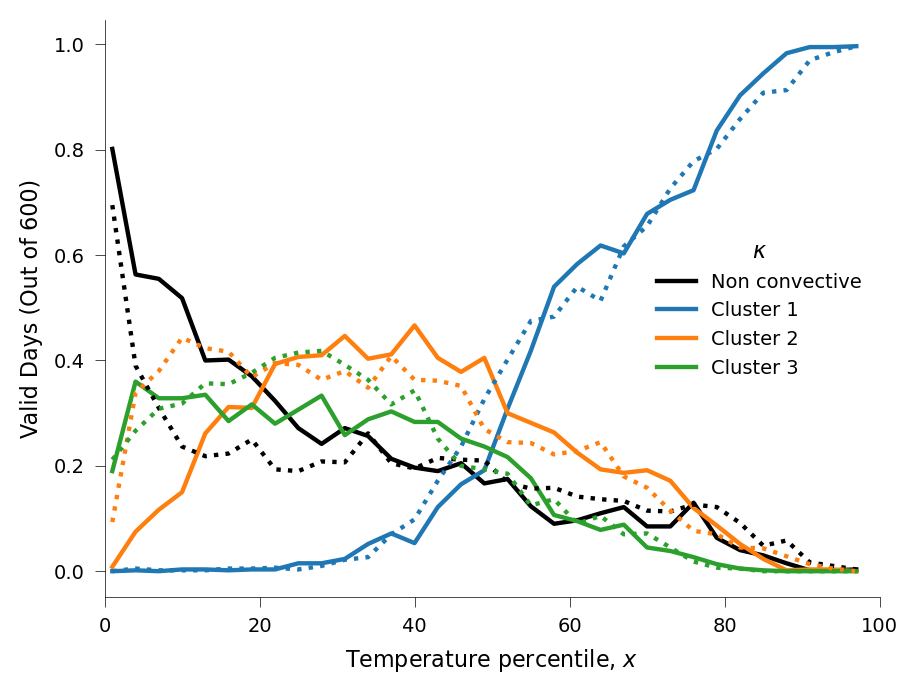

In [143]:
lat_ind_use = slice(0, 1)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    ax.plot(ds_quant.quant, np.average((~mask_use).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
                                       weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
            label="Non convective" if i == 0 else None, linestyle=[None, ':'][i], color='k')
    for j in range(n_clusters):
        ax.plot(ds_quant.quant,
                np.average(((cluster_ind == j) & (mask_use)).sum(dim='sample').isel(tau_lw=i, lat=lat_ind_use), axis=1,
                           weights=lat_weights.isel(lat=lat_ind_use)) / ds_quant.sample.size,
                linestyle=[None, ':'][i], color=f'C{j}', label=f'Cluster {j + 1}' if i == 0 else None)

ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
update_linewidth(fig)
ax.legend(title='$\kappa$')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


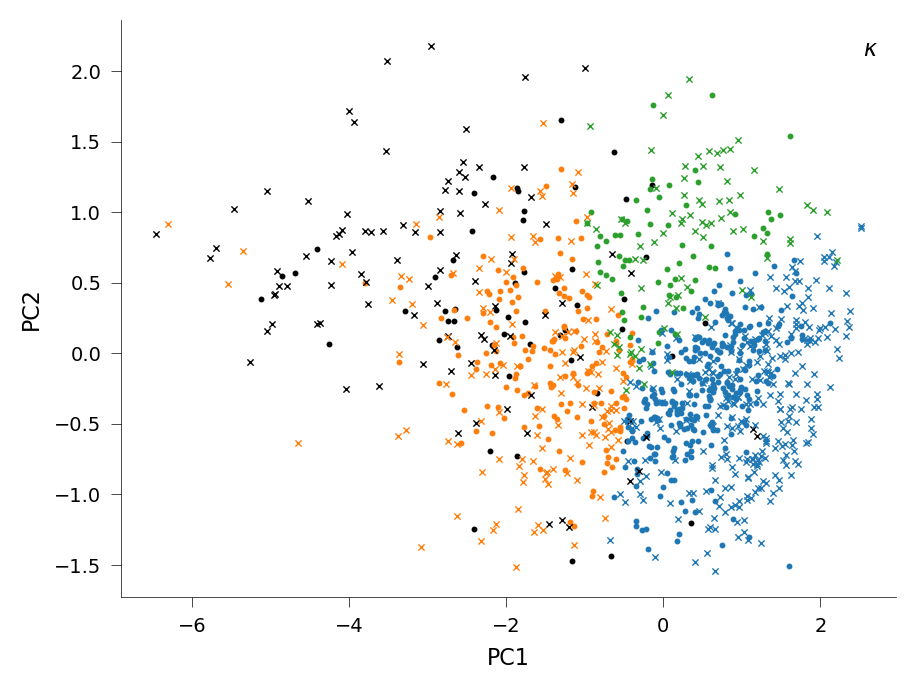

In [142]:
pc_output = pca_on_xarray(xr.concat(list(ds_pca.values()), dim="feature"), n_modes=3, feature_dim_name="feature",
                          valid=mask_use)
quant_use = slice(0, 200)
# lat_use = slice(0, 90)
quant_use = 19
lat_use = 0
var = pc_output[1].isel(quant=quant_use, lat=lat_use)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for i in range(ds_quant.tau_lw.size):
    mask_plot = ~mask_use.isel(quant=quant_use, lat=lat_use)
    ax.scatter(var.where(mask_plot).isel(mode=0, tau_lw=i),
               var.where(mask_plot).isel(mode=1, tau_lw=i), marker=['.', 'x'][i],
               s=5, c='k')
    for j in range(n_clusters):
        mask_plot = (mask_use.isel(quant=quant_use, lat=lat_use)) & (cluster_ind.isel(quant=quant_use, lat=lat_use) == j)
        ax.scatter(var.where(mask_plot).isel(mode=0, tau_lw=i),
                   var.where(mask_plot).isel(mode=1, tau_lw=i), marker=['.', 'x'][i], s=5, c=f'C{j}')
    # im = ax.scatter(var.isel(mode=0, tau_lw=0),
    #                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
    #                 c=ds_quant.TREFHT.where(mask_use * 0 + 1).isel(tau_lw=0, quant=quant_use, lat=lat_use),
    #                 alpha=0.3, label=var.tau_lw.values[0])
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=var.isel(mode=2, tau_lw=0),
#                 alpha=0.3, label=var.tau_lw.values[0])
# plt.colorbar(im, ax=ax)

# ax.scatter(var.isel(mode=0, tau_lw=0),
#            var.isel(mode=1, tau_lw=0), marker='.', s=1,
#            c='b', alpha=0.3, label=var.tau_lw.values[0])
# #
# ax.scatter(var.isel(mode=0, tau_lw=1),
#            var.isel(mode=1, tau_lw=1), marker='.', s=0.5,
#            c='y', alpha=0.3, label=var.tau_lw.values[1])


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax.legend(title='$\kappa$')
plt.show()


# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=-1), marker='.', s=1, color='C1')

# quant_use = -1
# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=1, lat=-1), marker='x', s=5, color='C0')
# plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=-1),
#             pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=-1), marker='x', s=5, color='C1')

# quant_use = -1
# plt.scatter(pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=0, mode=0),
#             pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=0, mode=1), marker='x', color='C0')
# plt.scatter(pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=1, mode=0),
#             pc_output[1].where(mask_use.isel(lat=-1)).isel(quant=quant_use, tau_lw=1, mode=1), marker='x', color='C1')
# plt.scatter(pc_output[1].isel(quant=0, tau_lw=1, mode=0), pc_output[1].isel(quant=0, tau_lw=1, mode=1))

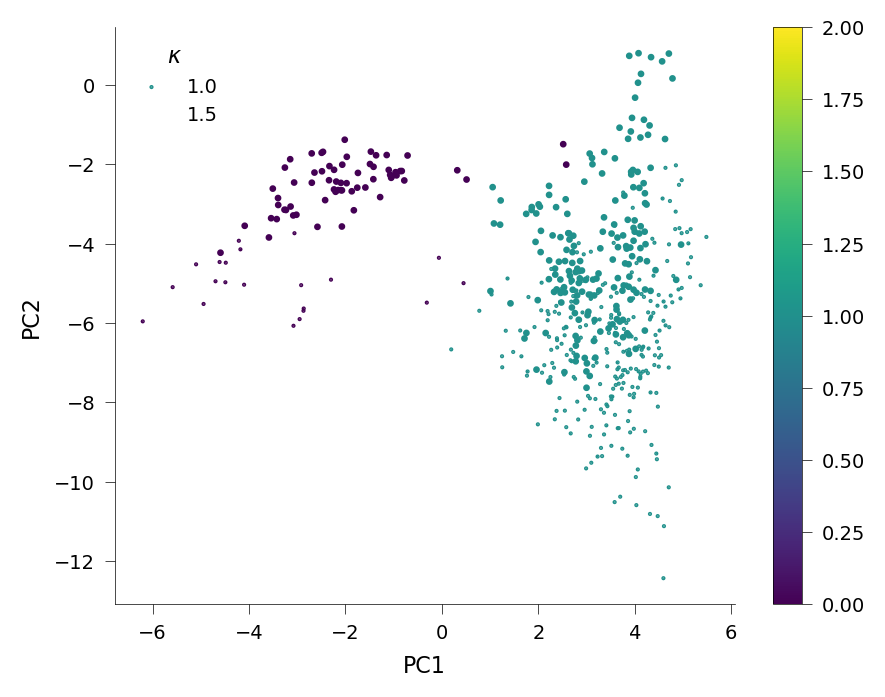

In [942]:
quant_use = slice(0, 200)
lat_use = slice(0, 90)
quant_use = 0
lat_use = -1
var = pc_output[1].where(mask_use).isel(quant=quant_use, lat=lat_use)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=ds_quant.TREFHT.where(mask_use * 0 + 1).isel(tau_lw=0, quant=quant_use, lat=lat_use),
#                 alpha=0.3, label=var.tau_lw.values[0])
# im = ax.scatter(var.isel(mode=0, tau_lw=0),
#                 var.isel(mode=1, tau_lw=0), marker='.', s=1,
#                 c=var.isel(mode=2, tau_lw=0),
#                 alpha=0.3, label=var.tau_lw.values[0])
im = ax.scatter(var.isel(mode=1, tau_lw=0),
                var.isel(mode=2, tau_lw=0), marker='.', s=1,
                c=labels.where(mask_use).isel(quant=quant_use, lat=lat_use, tau_lw=0),
                alpha=1, label=var.tau_lw.values[0], vmin=0, vmax=2)

im = ax.scatter(var.isel(mode=1, tau_lw=1),
                var.isel(mode=2, tau_lw=1), marker='o', s=2,
                c=labels.where(mask_use).isel(quant=quant_use, lat=lat_use, tau_lw=1),
                alpha=1, label=var.tau_lw.values[1], vmin=0, vmax=2)

plt.colorbar(im, ax=ax)

# ax.scatter(var.isel(mode=0, tau_lw=0),
#            var.isel(mode=1, tau_lw=0), marker='.', s=1,
#            c='b', alpha=0.3, label=var.tau_lw.values[0])
# #
# ax.scatter(var.isel(mode=0, tau_lw=1),
#            var.isel(mode=1, tau_lw=1), marker='.', s=0.5,
#            c='y', alpha=0.3, label=var.tau_lw.values[1])


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
# ax.set_title(f"Lat = {var.lat:.0f}$\degree$")
ax.legend(title='$\kappa$')
plt.show()

In [228]:
def value_counts_over_sample(da: xr.DataArray) -> xr.DataArray:
    """Count unique values along the sample dimension.

    Returns a DataArray with dims ('value', all other dims).
    """
    # identify all dims except sample
    other_dims = [d for d in da.dims if d != "sample"]

    # group along the sample dimension
    grouped = da.groupby(da).count("sample")

    # rename 'group' dim (the unique values)
    return grouped.rename({"group": "value"}).transpose("value", *other_dims)

In [941]:
np.unique(labels.where(mask_use).isel(quant=0, tau_lw=1, lat=-1).values, return_counts=True)

(array([ 0.,  1., nan]), array([ 65, 185, 350]))

(array([ 0.,  1., nan]), array([497,  91,  12]))
(array([ 0.,  1., nan]), array([506,  35,  59]))


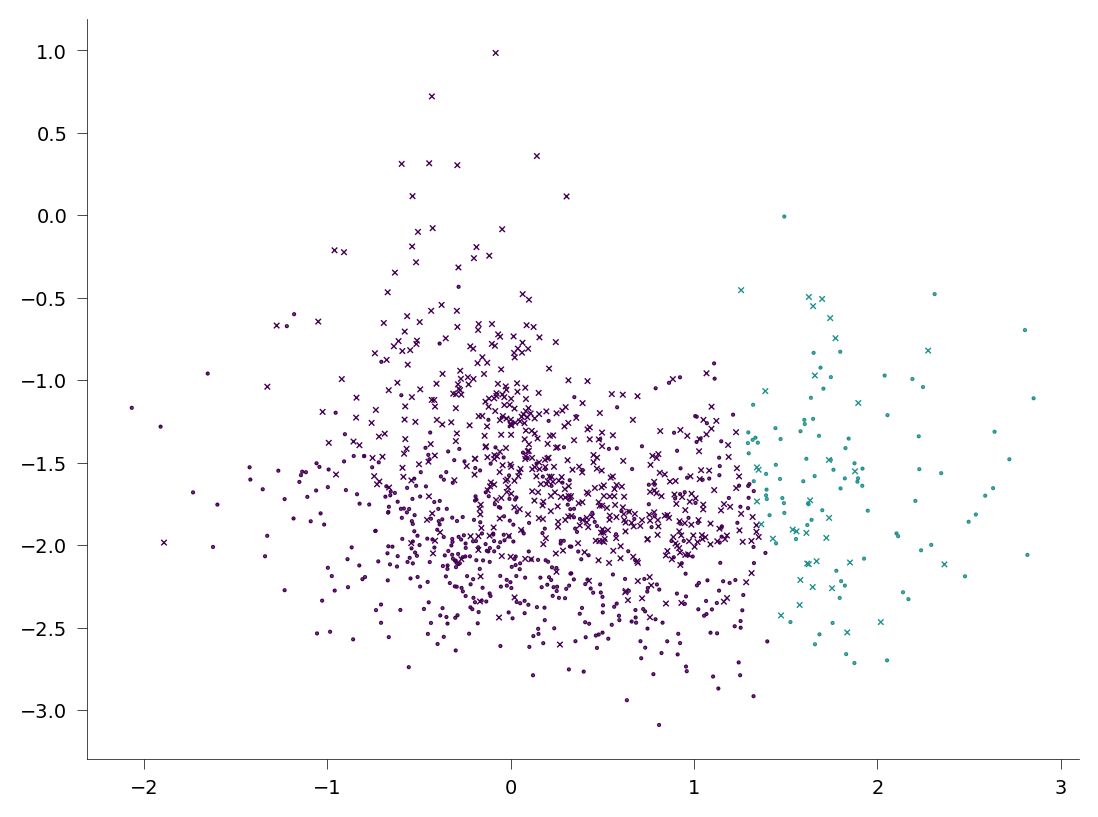

In [281]:
quant_use = slice(0, 90)
lat_use = slice(0, 90)
quant_use = -1
lat_use = -1

plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=0, lat=lat_use),
            pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=0, mode=1, lat=lat_use), marker='.', s=1,
            c=labels.where(mask_use).isel(quant=quant_use, tau_lw=0, lat=lat_use), vmin=0, vmax=2)
print(np.unique(labels.where(mask_use).isel(quant=quant_use, tau_lw=0, lat=lat_use).values, return_counts=True))

plt.scatter(pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=0, lat=lat_use),
            pc_output[1].where(mask_use).isel(quant=quant_use, tau_lw=1, mode=1, lat=lat_use), marker='x', s=4,
            c=labels.where(mask_use).isel(quant=quant_use, tau_lw=1, lat=lat_use), vmin=0, vmax=2)
print(np.unique(labels.where(mask_use).isel(quant=quant_use, tau_lw=1, lat=lat_use).values, return_counts=True))

In [221]:
from sklearn.metrics import silhouette_score


def evaluate_k_range(
        pcs_A: xr.DataArray,
        mask_A: xr.DataArray,
        ks: list[int],
        pcs_B: xr.DataArray = None,
        mask_B: xr.DataArray = None,
) -> xr.Dataset:
    """Compute clustering diagnostics (elbow, silhouette, stability) for each K.

    If pcs_B and mask_B are given, computes the centroid stability measure:
        S(K) = mean_k ||μ_Ak - μ_ABk|| + ||μ_Bk - μ_ABk||

    Args:
        pcs_A: First dataset PCs (dims: quant, tau_lw, lat, sample, mode).
        mask_A: Boolean mask for dataset A.
        ks: List of cluster counts to evaluate.
        pcs_B: Optional second dataset PCs.
        mask_B: Corresponding mask.

    Returns:
        xr.Dataset containing diagnostics for each K:
            - inertia
            - silhouette
            - stability (if pcs_B provided)
    """
    results = {}

    # Stack once per dataset to avoid overhead
    def prepare(pcs, mask):
        pcs_st = pcs.stack(point=("quant", "lat", "sample"))
        mask_st = mask.stack(point=("quant", "lat", "sample"))
        X = pcs_st.transpose("point", "mode").values
        X_mask = pcs_st.sel(point=mask_st).transpose("point", "mode").values
        return pcs_st, mask_st, X, X_mask

    pcsA_st, maskA_st, XA_full, XA_mask = prepare(pcs_A, mask_A)
    if pcs_B is not None:
        pcsB_st, maskB_st, XB_full, XB_mask = prepare(pcs_B, mask_B)
        # Combined dataset for AB fit
        XAB_mask = np.vstack([XA_mask, XB_mask])
    else:
        XAB_mask = None

    for K in ks:
        kmA = KMeans(n_clusters=K, n_init="auto").fit(XA_mask)
        inertia = kmA.inertia_
        sil = silhouette_score(XA_mask, kmA.labels_) if len(set(kmA.labels_)) > 1 else np.nan

        # Default output for a single dataset
        entry = dict(inertia=inertia, silhouette=sil)

        # If two datasets supplied, compute stability
        if pcs_B is not None:
            kmB = KMeans(n_clusters=K, n_init="auto").fit(XB_mask)
            kmAB = KMeans(n_clusters=K, n_init="auto").fit(XAB_mask)

            muA = kmA.cluster_centers_
            muB = kmB.cluster_centers_
            muAB = kmAB.cluster_centers_

            # Compute ∥μA−μAB∥ + ∥μB−μAB∥ per k, then average
            stab = np.mean(
                np.linalg.norm(muA - muAB, axis=1) +
                np.linalg.norm(muB - muAB, axis=1)
            )
            entry["stability"] = stab

        results[K] = entry

    # Convert to xarray
    ds = xr.Dataset(
        {
            k: xr.DataArray(
                [results[k]["inertia"],
                 results[k]["silhouette"]] +
                ([results[k]["stability"]] if pcs_B is not None else []),
                dims=["metric"],
                coords=dict(metric=(["metric"],
                                    ["inertia", "silhouette"] +
                                    (["stability"] if pcs_B is not None else [])
                                    ))
            )
            for k in ks
        }
    )

    return ds

In [225]:
kmeans_diagnostics = evaluate_k_range(pc_output[1].isel(tau_lw=0), mask_use.isel(tau_lw=0), [2, 3, 4, 5],
                                      pc_output[1].isel(tau_lw=1), mask_use.isel(tau_lw=1))

In [226]:
kmeans_diagnostics

<xarray.Dataset> Size: 216B
Dimensions:  (metric: 3)
Coordinates:
  * metric   (metric) <U10 120B 'inertia' 'silhouette' 'stability'
Data variables:
    2        (metric) float64 24B 2.02e+05 0.4967 4.695
    3        (metric) float64 24B 1.173e+05 0.4346 3.634
    4        (metric) float64 24B 9.768e+04 0.3795 2.485
    5        (metric) float64 24B 7.905e+04 0.3642 4.477